##### This notebook is to be viewed together with "06 Annex-1 Part 1 (Regression)".

# Import Packages

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline
%config IPCompleter.greedy=True
# df = pd.read_csv('df_model.csv') # modelling dataset
# df = pd.read_csv('df_model_with_dummies.csv') # modeling dataset
df = pd.read_csv('df_model_with_dummies_debug.csv') # modeling dataset
sns.set(style='darkgrid')
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor

In [0]:
df.head(2)

,year,company,auwgr,lkpp,hlr_lag1,hlr_lag2,hlr_lag3,hlr_lag4,hlr_lag5,mer,der,oer,prem_write_net_lag1,claim_set_net_lag1,exp_management_lag1,exp_comm_incur_net_lag1,exp_other_lag1,prem_liab_diff_lag1,claim_liab_diff_lag1,class_bonds,class_cnstr_engr,class_cpr,class_fire,class_health,class_mac,class_mahl,class_motor,class_others,class_pa,class_prof_indm,class_pub_lia,class_wic
0,2005,c166,0.857689,4.440529,0.80076,0.801708,0.800061,0.78091,0.741233,0.294635,-0.208663,0.007911,1.079745e+07,1.672463e+06,3.029820e+06,-2.145740e+06,81347.307692,229526.538462,529578.846154,0,0,0,1,0,0,0,0,0,0,0,0,0
1,2006,c166,0.734340,5.104554,0.67756,0.801708,0.800061,0.78091,0.741233,0.334138,-0.403902,0.013492,6.799853e+06,8.911880e+05,2.163894e+06,-2.615691e+06,87377.000000,-460009.000000,900936.000000,0,0,0,1,0,0,0,0,0,0,0,0,0


In [0]:
# df_fire = df[df['class']=='fire'].copy()
df_fire = df.copy() # take ALL THE DATA
df_fire.shape

(6353, 32)

In [0]:
def find_threshold_count(df_arg, col_name, min_thresh, max_thresh):
    counter_min=df_arg[df_arg[col_name]< min_thresh].count().head(1).values[0]
    counter_pct_min=round(100*(df_arg[df_arg[col_name]< min_thresh].count().head(1).values[0]/num_rows),2)
    counter_max=df_arg[df_arg[col_name]> max_thresh].count().head(1).values[0]
    counter_pct_max=round(100*(df_arg[df_arg[col_name]> max_thresh].count().head(1).values[0]/num_rows),2)
    print('column name:', col_name)
    print('no. of rows with values less than',min_thresh,'=>\t',counter_min,'(',counter_pct_min,'% )')
    print('no. of rows with values more than',max_thresh,'=>\t',counter_max,'(',counter_pct_max,'% )')
    print('total percentage of rows beyond min/max thresholds:',round(counter_pct_min+counter_pct_max,2),'%')
    return None

def drop_outside_threshold(df_arg, col_name, min_thresh, max_thresh):
    old_shape = df_arg.shape
    try:
        idx_list = list(df_arg[(df_arg[col_name]<min_thresh) | (df_arg[col_name]>max_thresh)].index.values)
    except:
        print("No such cases found...")
    else:
        if len(idx_list) > 0:
            df_arg.drop(index=idx_list,inplace=True)
    finally:
        print('Dropped',len(idx_list),'rows...')
        print('Old shape =>',old_shape)
        print('New shape =>',df_arg.shape)
    return None

# Prepare Data, Train/Test Split

In [0]:
# df_fire
features = [col for col in df_fire._get_numeric_data().columns if (col != 'auwgr') and (col != 'year')]
X = df_fire[features]
y = df_fire['auwgr']
print(X.shape, y.shape)

(6353, 29) (6353,)


In [0]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(4764, 29) (1589, 29) (4764,) (1589,)


# Standard Scaler

In [0]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

# AdaBoost Regressor

## Initial Hyperparameters (using Scaled Data)

In [0]:
abreg = AdaBoostRegressor()
abreg.fit(X_train_sc,y_train)
print(abreg.score(X_train_sc,y_train))
print(abreg.score(X_test_sc,y_test))

0.9988405726187367
0.0027676290890391586


## GridSearchCV (cv=3)

In [0]:
ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor())
param_grid = {
    'n_estimators' : [150,200,250,300,350],
    'base_estimator__max_depth' : [2,3,4,5],
    'learning_rate' : [0.6,0.7,0.8,0.9,1],
    'random_state' : [42]
}
reg = GridSearchCV(ada, param_grid, cv=3)
reg.fit(X_train_sc, y_train)
reg.best_params_

{'base_estimator__max_depth': 5,
 'learning_rate': 1,
 'n_estimators': 150,
 'random_state': 42}

In [0]:
ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor())
param_grid = {
    'n_estimators' : [10, 20, 30, 40],
    'base_estimator__max_depth' : [4,5,6],
    'learning_rate' : [0.9,1,1.1],
    'random_state' : [42]
}
reg = GridSearchCV(ada, param_grid, cv=3)
reg.fit(X_train_sc, y_train)
reg.best_params_

{'base_estimator__max_depth': 5,
 'learning_rate': 1,
 'n_estimators': 30,
 'random_state': 42}

In [0]:
abreg = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5),learning_rate=1,n_estimators=30,random_state=42)
abreg.fit(X_train_sc,y_train)
print(abreg.score(X_train_sc,y_train))
print(abreg.score(X_test_sc,y_test))

0.997988301632424
-0.0002451312904618863


## Initial Hyperparameters (using UnScaled Data)

In [0]:
abreg = AdaBoostRegressor()
abreg.fit(X_train,y_train)
print(abreg.score(X_train,y_train))
print(abreg.score(X_test,y_test))

0.9996835382350844
0.002588763408910011


## GridSearchCV (cv=3)

In [0]:
ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor())
param_grid = {
    'n_estimators' : [100,150,200],
    'base_estimator__max_depth' : [2,3,4,5],
    'learning_rate' : [0.6,0.7,0.8,0.9,1],
    'random_state' : [42]
}
reg = GridSearchCV(ada, param_grid, cv=3)
reg.fit(X_train, y_train)
reg.best_params_

{'base_estimator__max_depth': 5,
 'learning_rate': 0.8,
 'n_estimators': 150,
 'random_state': 42}

In [0]:
abreg = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5),learning_rate=0.8,n_estimators=100,random_state=42)
abreg.fit(X_train,y_train)
print(abreg.score(X_train,y_train))
print(abreg.score(X_test,y_test))

0.9993977746534836
0.0006256119297525231


# Gradient Boosting Regressor

## Initial Hyperparameters (using Scaled Data)

In [0]:
gbreg = GradientBoostingRegressor(loss='ls',random_state=42)
gbreg.fit(X_train_sc,y_train)
print(gbreg.score(X_train_sc,y_train))
print(gbreg.score(X_test_sc,y_test))

0.9999031783644269
-0.3890761721937448


In [0]:
gbreg = GradientBoostingRegressor(loss='huber',random_state=42) # alpha = 0.9 (default)
gbreg.fit(X_train_sc,y_train)
print(gbreg.score(X_train_sc,y_train))
print(gbreg.score(X_test_sc,y_test))

0.3153174660746694
-0.035799391961917726


In [0]:
gbreg = GradientBoostingRegressor(loss='lad',random_state=42)
gbreg.fit(X_train_sc,y_train)
print(gbreg.score(X_train_sc,y_train))
print(gbreg.score(X_test_sc,y_test))

-0.00033611927533461206
1.4785931534477825e-05


In [0]:
gbreg = GradientBoostingRegressor(loss='quantile',random_state=42,alpha=0.4) # alpha = 0.9 (default)
gbreg.fit(X_train_sc,y_train)
print(gbreg.score(X_train_sc,y_train))
print(gbreg.score(X_test_sc,y_test))

0.031221679654044876
0.0017995140095682371


## GridSearchCV (cv=3) using loss function 'huber'

In [0]:
param_grid = {
    'n_estimators' : [100,150,200,250,300],
    'loss' : ['huber'],
    'max_depth' : [2,3,4],
    'learning_rate' : [0.07,0.08,0.09,0.1],
    'alpha' : [0.1,0.3,0.5,0.7,0.9],
    'random_state' : [42]
}
reg = GridSearchCV(GradientBoostingRegressor(), param_grid, cv=3)
reg.fit(X_train_sc, y_train)
reg.best_params_

{'alpha': 0.7,
 'learning_rate': 0.08,
 'loss': 'huber',
 'max_depth': 3,
 'n_estimators': 250,
 'random_state': 42}

In [0]:
gbreg = GradientBoostingRegressor(loss='huber',alpha=0.7,learning_rate=0.08,max_depth=3,n_estimators=250,random_state=42)
gbreg.fit(X_train_sc,y_train)
print(gbreg.score(X_train_sc,y_train))
print(gbreg.score(X_test_sc,y_test))

0.1778783217684795
-0.043980841918411784


## GridSearchCV (cv=3) using loss function 'ls'

In [0]:
param_grid = {
    'n_estimators' : [100,150,200,250,300],
    'loss' : ['ls'],
    'max_depth' : [2,3,4],
    'learning_rate' : [0.05,0.06,0.07,0.08,0.09,0.1],
    'random_state' : [42]
}
reg = GridSearchCV(GradientBoostingRegressor(), param_grid, cv=3)
reg.fit(X_train_sc, y_train)
reg.best_params_

{'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 4,
 'n_estimators': 300,
 'random_state': 42}

In [0]:
gbreg = GradientBoostingRegressor(loss='ls',learning_rate=0.1,max_depth=4,n_estimators=300,random_state=42)
gbreg.fit(X_train_sc,y_train)
print(gbreg.score(X_train_sc,y_train))
print(gbreg.score(X_test_sc,y_test))

0.9999946338370853
-0.3869801624462441


## GridSearchCV (cv=3) using loss function 'lad'

In [0]:
param_grid = {
    'n_estimators' : [100,150,200],
    'loss' : ['lad'],
    'max_depth' : [3,4,5],
    'learning_rate' : [0.04,0.05,0.06],
    'random_state' : [42]
}
reg = GridSearchCV(GradientBoostingRegressor(), param_grid, cv=3)
reg.fit(X_train_sc, y_train)
reg.best_params_

{'learning_rate': 0.06,
 'loss': 'lad',
 'max_depth': 4,
 'n_estimators': 100,
 'random_state': 42}

In [0]:
gbreg = GradientBoostingRegressor(loss='lad',learning_rate=0.06,max_depth=4,n_estimators=100,random_state=42)
gbreg.fit(X_train_sc,y_train)
print(gbreg.score(X_train_sc,y_train))
print(gbreg.score(X_test_sc,y_test))

0.28808853975306115
0.0007865776742761454


# Clustering (Unsupervised Learning)

## Prepare and Scale Data

In [0]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [0]:
df_cluster = pd.read_csv('df_model.csv') # modeling dataset

In [0]:
df_cluster.head()

,year,company,class,auwgr,lkpp,amlr,amer,der,aoer
0,2005,c166,mahl,0.241854,1.505486,0.865390,0.021265,0.036815,0.000859
1,2006,c166,mahl,-0.867997,2.534810,1.397724,0.074598,0.371861,0.002904
2,2007,c166,mahl,10.434234,0.836520,2.218928,0.222687,-3.385768,0.007512
3,2008,c166,mahl,-0.001043,-0.157507,3.099674,6.047065,-0.119973,0.185180
4,2009,c166,mahl,-0.598818,1.211453,2.479259,1.246263,0.224976,0.042442


In [0]:
df_cluster.drop(columns=['aoer'],inplace=True)

In [0]:
# drop_outside_threshold(df_cluster,'auwgr',-2,2)
# drop_outside_threshold(df_cluster,'lkpp',-5,13)
# drop_outside_threshold(df_cluster,'amlr',-1,2.2)
# drop_outside_threshold(df_cluster,'amer',0,5)
# drop_outside_threshold(df_cluster,'der',-1,2)
# # drop_outside_threshold(df_cluster,'aoer',0,0.2)

In [0]:
df_cluster.drop(columns=['year','company','class'],inplace=True)
df_cluster.head(2)

,auwgr,lkpp,amlr,amer,der
0,0.241854,1.505486,0.865390,0.021265,0.036815
1,-0.867997,2.534810,1.397724,0.074598,0.371861


In [0]:
df_cluster.shape

(6790, 5)

In [0]:
ss=StandardScaler()
X_scaled = ss.fit_transform(df_cluster)

## DBSCAN

In [0]:
# DEFAULT SETTINGS
# DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
#        metric_params=None, min_samples=5, n_jobs=None, p=None)
DBSCAN()

In [0]:
# below was used without dropping aoer and without dropping rows
dbscan = DBSCAN(eps=0.01,min_samples=5)
dbscan.fit(X_scaled)
print(set(dbscan.labels_))
print(silhouette_score(X_scaled,dbscan.labels_))
df_cluster['cluster'] = dbscan.labels_
df_cluster['cluster'].value_counts()

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -1}
0.006489441248184589


 0     6113
-1      569
 7       12
 3       12
 1       12
 5       11
 9       10
 8        8
 6        7
 13       7
 11       6
 10       6
 2        6
 4        6
 12       5
Name: cluster, dtype: int64

In [0]:
# below was used with dropping aoer and with dropping rows
dbscan = DBSCAN(eps=0.70,min_samples=3)
dbscan.fit(X_scaled)
print(set(dbscan.labels_))
print(silhouette_score(X_scaled,dbscan.labels_))
df_cluster['cluster'] = dbscan.labels_
df_cluster['cluster'].value_counts()

In [0]:
# below was used without dropping aoer but with dropping rows
dbscan = DBSCAN(eps=0.398,min_samples=15)
dbscan.fit(X_scaled)
print(set(dbscan.labels_))
print(silhouette_score(X_scaled,dbscan.labels_))
df_cluster['cluster'] = dbscan.labels_
df_cluster['cluster'].value_counts()

## GridSearch DBSCAN

In [0]:
from collections import Counter

def dbscan_grid_search(X_data, lst, clst_count, eps_space = 0.5,
                       min_samples_space = 5, min_clust = 0, max_clust = 10):
      # Importing counter to count the amount of data in each cluster

    # Starting a tally of total iterations
    n_iterations = 0

    # Looping over each combination of hyperparameters
    for eps_val in eps_space:
        for samples_val in min_samples_space:

            dbscan_grid = DBSCAN(eps = eps_val,
                                 min_samples = samples_val)

            # fit_transform
            clusters = dbscan_grid.fit_predict(X = X_data)

            # Counting the amount of data in each cluster
            cluster_count = Counter(clusters)

            # Saving the number of clusters
            n_clusters = sum(abs(pd.np.unique(clusters))) - 1

            # Increasing the iteration tally with each run of the loop
            n_iterations += 1

            # Appending the lst each time n_clusters criteria is reached
            if n_clusters >= min_clust and n_clusters <= max_clust:

                dbscan_clusters.append([eps_val,
                                        samples_val,
                                        n_clusters])

                clst_count.append(cluster_count)

    # Printing grid search summary information
    print(f"""Search Complete. \nYour list is now of length {len(lst)}. """)
    print(f"""Hyperparameter combinations checked: {n_iterations}. \n""")

In [0]:
# Setting empty lists in global environment
dbscan_clusters = []
cluster_count   = []

# Inputting function parameters
dbscan_grid_search(X_data = X_scaled,
                   lst = dbscan_clusters,
                   clst_count = cluster_count,
                   eps_space = pd.np.arange(0.001, .5, 0.001),
                   min_samples_space = pd.np.arange(2, 10, 1),
                   min_clust = 3,
                   max_clust = 10)

Search Complete. 
Your list is now of length 1137. 
Hyperparameter combinations checked: 3992. 



In [0]:
print(dbscan_clusters)
print(cluster_count)

[[0.008, 9, 6], [0.009000000000000001, 9, 3], [0.010000000000000002, 7, 3], [0.010000000000000002, 9, 6], [0.011, 9, 3], [0.012, 8, 10], [0.013000000000000001, 8, 10], [0.013000000000000001, 9, 10], [0.014000000000000002, 9, 10], [0.016, 9, 10], [0.017, 6, 10], [0.017, 7, 10], [0.018000000000000002, 7, 10], [0.019000000000000003, 7, 10], [0.019000000000000003, 9, 10], [0.02, 6, 10], [0.02, 8, 10], [0.02, 9, 10], [0.021, 6, 3], [0.021, 7, 3], [0.021, 8, 10], [0.022000000000000002, 6, 6], [0.022000000000000002, 7, 3], [0.022000000000000002, 8, 6], [0.023, 7, 3], [0.023, 8, 3], [0.023, 9, 6], [0.024, 7, 6], [0.024, 8, 3], [0.024, 9, 3], [0.025, 7, 10], [0.025, 9, 3], [0.026000000000000002, 7, 6], [0.026000000000000002, 8, 3], [0.027000000000000003, 7, 6], [0.027000000000000003, 8, 3], [0.028, 6, 10], [0.028, 7, 6], [0.028, 8, 3], [0.028, 9, 3], [0.029, 6, 10], [0.029, 7, 6], [0.029, 8, 3], [0.029, 9, 3], [0.030000000000000002, 6, 10], [0.030000000000000002, 7, 6], [0.030000000000000002, 8

In [0]:
cluster0_size_min = 100000 # initialize with a large number
for i in range(0,len(cluster_count)):
  if cluster_count[i][0] < cluster0_size_min:
    cluster0_size_min = cluster_count[i][0]
print('smallest size of cluster 0 is', cluster0_size_min)

smallest size of cluster 0 is 5928


In [0]:
cluster1_size_max = 0
for i in range(0,len(cluster_count)):
  if cluster_count[i][1] > cluster1_size_max:
    cluster1_size_max = cluster_count[i][1]
print('largest size of cluster 1 is', cluster1_size_max)

largest size of cluster 1 is 35


In [0]:
cluster2_size_max = 0
for i in range(0,len(cluster_count)):
  if cluster_count[i][2] > cluster2_size_max:
    cluster2_size_max = cluster_count[i][2]
print('largest size of cluster 2 is', cluster2_size_max)

largest size of cluster 2 is 29


In [0]:
cluster_minus1_size_max = 0
for i in range(0,len(cluster_count)):
  if cluster_count[i][-1] > cluster_minus1_size_max:
    cluster_minus1_size_max = cluster_count[i][-1]
print('largest size of cluster -1 is', cluster_minus1_size_max)

largest size of cluster -1 is 812


## K-MEANS

In [0]:
len(X_scaled)

6790

In [0]:
from sklearn.cluster import KMeans

In [0]:
km=KMeans(n_clusters=5, random_state=42,tol=0.0001)
km.fit(X_scaled)
print('no. of iterations:', km.n_iter_)

no. of iterations: 3


In [0]:
km.inertia_

11597.045269213015

In [0]:
df_cluster['cluster'] = km.labels_
df_cluster.head()

,auwgr,lkpp,amlr,amer,der,cluster
0,0.241854,1.505486,0.865390,0.021265,0.036815,0
1,-0.867997,2.534810,1.397724,0.074598,0.371861,0
2,10.434234,0.836520,2.218928,0.222687,-3.385768,0
3,-0.001043,-0.157507,3.099674,6.047065,-0.119973,0
4,-0.598818,1.211453,2.479259,1.246263,0.224976,0


In [0]:
df_cluster['cluster'].value_counts()

0    6786
3       1
2       1
1       1
4       1
Name: cluster, dtype: int64

In [0]:
KMeans()

In [0]:
min_clusters=10
max_clusters=50
scores = []
for k in range(min_clusters, max_clusters+1):
    cl = KMeans(n_clusters=k, random_state=42,tol=0.000000000000000001)
    cl.fit(X_scaled)
    inertia = cl.inertia_
    sil = silhouette_score(X_scaled, cl.labels_)
    scores.append([k, inertia, sil])
    
score_df = pd.DataFrame(scores)
score_df.columns = ['k', 'inertia', 'silhouette']
score_df.tail()

,k,inertia,silhouette
36,46,24.210535,0.545255
37,47,22.564045,0.545046
38,48,21.052314,0.547521
39,49,19.721099,0.474172
40,50,18.363686,0.534119


Text(0.5, 1.0, 'Silhouette Score over k')

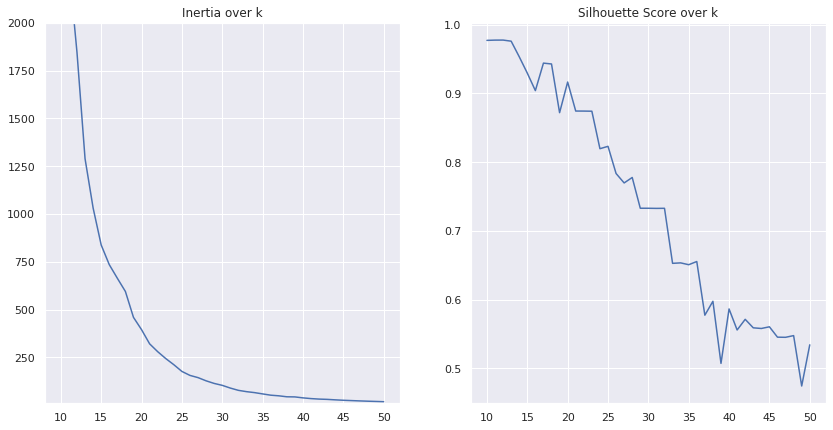

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].plot(score_df.k, score_df.inertia)
axes[0].set_title('Inertia over k')
axes[0].set_ylim(10,2000)
axes[1].plot(score_df.k, score_df.silhouette);
axes[1].set_title('Silhouette Score over k')

In [0]:
# based on above plots, select k
km=KMeans(n_clusters=50, random_state=42,tol=0.000000000000000001)
num_iterations = km.fit(X_scaled)
print('num iterations:',km.n_iter_)
print('inertia:',km.inertia_)
print('silhouette score:',silhouette_score(X_scaled, km.labels_))
df_cluster['cluster'] = km.labels_

num iterations: 42
inertia: 18.36368606289952
silhouette score: 0.5341188641515977


In [0]:
df_cluster['cluster'].value_counts().head(15) # first 15 rows

0     3861
30    1015
40    1007
32     267
49     254
48      84
22      84
35      42
25      34
31      27
37      13
45      12
17       9
38       7
34       7
Name: cluster, dtype: int64

In [0]:
df_cluster.head(1)

,auwgr,lkpp,amlr,amer,der,cluster
0,0.241854,1.505486,0.86539,0.021265,0.036815,0


In [0]:
df_cluster.sort_values(by='cluster')

,auwgr,lkpp,amlr,amer,der,cluster
0,0.241854,1.505486,0.865390,0.021265,0.036815,0
4000,0.708619,0.562287,3.430008,0.299542,0.158162,0
3994,0.346123,1.768853,7.103584,0.218639,0.169139,0
3993,0.021842,2.456157,5.992730,0.181517,0.165966,0
3992,-0.029687,1.462711,1.306696,0.162552,0.151766,0
...,...,...,...,...,...,...
1820,0.458492,17.731961,1.349623,0.426928,-0.037482,49
332,0.303972,11.835881,0.410344,0.442105,-0.270490,49
744,0.187360,11.027251,0.896518,0.303636,0.100140,49
6287,-1.091383,12.899899,1.086688,4.094336,-2.338917,49


In [0]:
df_cluster.to_csv('df_cluster_kmeans.csv')

## HIERARCHICAL

In [0]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist

In [0]:
X_scaled.shape

(6790, 5)

In [0]:
Z = linkage(X_scaled, 'single')

In [0]:
Z.shape

(6789, 4)

In [0]:
# Put Z in to DataFrame for easy display
link = pd.DataFrame(Z, columns=['cluster_index_left', 'cluster_index_right', 'distance', 'support'])
link.head()

,cluster_index_left,cluster_index_right,distance,support
0,6605.0,6607.0,0.000021,2.0
1,1061.0,1063.0,0.000023,2.0
2,6303.0,6304.0,0.000034,2.0
3,2221.0,2225.0,0.000034,2.0
4,1268.0,3708.0,0.000035,2.0


In [0]:
# Show cophenetic coefficient
c, coph_dists = cophenet(Z, pdist(X_scaled))
c

0.9403956440031981

In [0]:
import sys
sys.setrecursionlimit(10000)

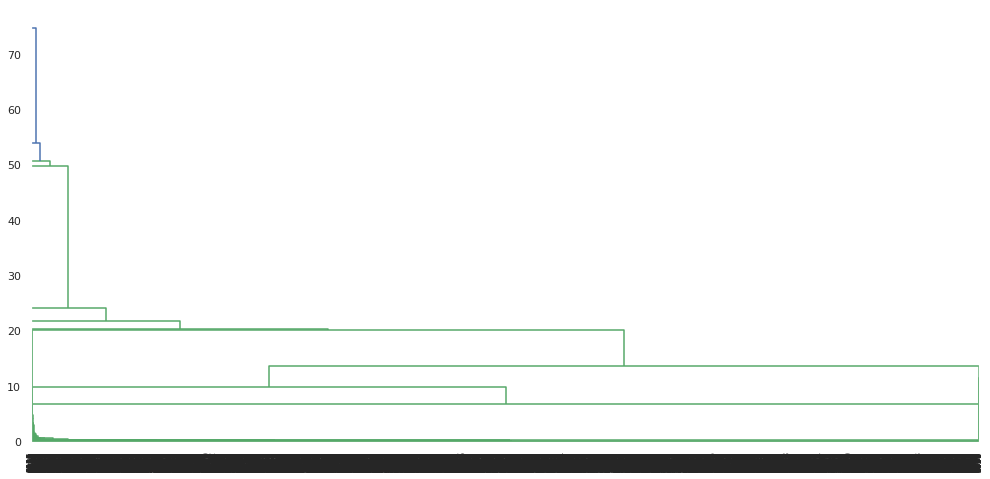

In [0]:
plt.figure(figsize=(17,8))
dendrogram(Z, leaf_rotation=90., leaf_font_size=8.);